In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import pytorch_ssim
import numpy as np
import copy
import cv2

In [47]:
"""

brick_wall.jpg
lacelike.jpg
pebbles.jpg
radish.jpg
red-peppers.jpg

einstein.png

"""

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
imsize = 256
nc = 1

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor

def cv_converter(img):
    image = Image.fromarray(img[...,::-1])
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)    
 
    
def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)


class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

    
# class ContentLoss(nn.Module):

#     def __init__(self, target,):
#         super(ContentLoss, self).__init__()
#         # we 'detach' the target content from the tree used
#         # to dynamically compute the gradient: this is a stated value,
#         # not a variable. Otherwise the forward method of the criterion
#         # will throw an error.
#         self.target = target.detach()

#     def forward(self, input):
#         self.loss = F.mse_loss(input, self.target)
#         return input


class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input




In [48]:
ref_img = image_loader("./data/texture/einstein.png")

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
cnn = models.vgg19(pretrained=True).features.to(device).eval()

unloader = transforms.ToPILImage()  # reconvert into PIL image

def imshow(tensor, title=None):
    tensor = torch.clamp(tensor,0,1)
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    #plt.savefig('pebbles_noise_2.jpg',dpi = 300)
    plt.show()

    
def imshow1(tensor, title=None):
    tensor = torch.clamp(tensor,0,1)
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    #plt.savefig('pebbles_noise_3.jpg',dpi = 300)
    plt.show()
# plt.figure()
# imshow(ref_img, title='reference texture')

In [49]:
"""


texture network



"""

#content_layers_default = ['conv_4']
#style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
style_layers_default = ['conv_1','pool_2', 'pool_4', 'pool_8', 'pool_12']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, 
                               #content_img,
                               #content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    #content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

#         if name in content_layers:
#             # add content loss:
#             target = model(content_img).detach()
#             content_loss = ContentLoss(target)
#             model.add_module("content_loss_{}".format(i), content_loss)
#             content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)
    
    print(model)
    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
#         if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
#             break
         #print(i)
         if isinstance(model[i], StyleLoss):
             break

    model = model[:(i + 1)]

    return model, style_losses     #, content_losses




# def get_input_optimizer(input_img):
#     # this line to show that input is a parameter that requires a gradient
#     optimizer = optim.LBFGS([input_img.requires_grad_()])
#     return optimizer

In [296]:
weight_mse = 2e4
weight_gram = 1e5
weight_ssim = 2e2

def model_gram(model, img, losses):
    
    
    img.requires_grad_()
    
    model(img)
    style_score = 0
    for sl in style_losses:
        style_score += weight_gram*sl.loss
    style_score.backward()
    
    return style_score, img.grad.flatten()

def mse(img,ref):
    
    
    img.requires_grad_()
    
    N = nc*imsize*imsize
    loss = weight_mse*((img-ref)**2).sum() / (N)
    loss.backward()

    return loss, img.grad.flatten()

def ssim(img, ref):
    
    
    img.requires_grad_()
    
    ssim_value = pytorch_ssim.ssim(ref, img)
    ssim_loss = pytorch_ssim.SSIM()
    ssim_out = -weight_ssim*ssim_loss(ref, img)
    ssim_out.backward()
    
    return ssim_value, img.grad.flatten()


def mse_opt(m0, temp, ref):
    
    temp.requires_grad_()
  
    N = nc*imsize*imsize
    loss_mse = weight_mse*((temp-ref)**2).sum() / (N)
    comp = (m0-loss_mse)**2
   # print('comp',comp,m0-loss_mse,m0,loss_mse)
    comp.backward()

    return comp, temp.grad

In [297]:
"""

Adam


"""

def Adam(m0, xm, ref, mkeep_opt):
    
    lr = 0.01
    beta_1 = 0.9
    beta_2 = 0.999
    epsilon = 1e-8

    theta_0 = 0
    m_t = 0 
    v_t = 0 
    t = 0
    
    var = 1
    while var == 1:
        t += 1
        #print('t',t)
        comp, g_t = mkeep_opt(m0,xm.detach(),ref.detach())
        m_t = beta_1*m_t + (1-beta_1)*g_t     # consider 90% of previous, and 10% of current
        v_t = beta_2*v_t + (1-beta_2)*(g_t*g_t) # 99.9% of previous (square grad), and 1% of current
        m_cap = m_t/(1-(beta_1**t))      #calculates the bias-corrected estimates
        v_cap = v_t/(1-(beta_2**t))      #calculates the bias-corrected estimates
        
        xm_prev = xm
        xm = xm - (lr*m_cap)/(torch.sqrt(v_cap)+epsilon)
        if comp < 1e-10:    #checks if it is converged or not
            break
            
    return comp, xm 

In [351]:
def search_grad(ref, g, gkeep, img = None, mkeep = None, lamda = None):
    """

Adam


"""

def Adam(m0, xm, ref, mkeep_opt):
    
    lr = 0.01
    beta_1 = 0.9
    beta_2 = 0.999
    epsilon = 1e-8

    theta_0 = 0
    m_t = 0 
    v_t = 0 
    t = 0
    
    var = 1
    while var == 1:
        t += 1
        #print('t',t)
        comp, g_t = mkeep_opt(m0,xm.detach(),ref.detach())
        m_t = beta_1*m_t + (1-beta_1)*g_t     # consider 90% of previous, and 10% of current
        v_t = beta_2*v_t + (1-beta_2)*(g_t*g_t) # 99.9% of previous (square grad), and 1% of current
        m_cap = m_t/(1-(beta_1**t))      #calculates the bias-corrected estimates
        v_cap = v_t/(1-(beta_2**t))      #calculates the bias-corrected estimates
        
        xm_prev = xm
        xm = xm - (lr*m_cap)/(torch.sqrt(v_cap)+epsilon)
        if comp < 1e-10:    #checks if it is converged or not
            break
            
    return comp, xm 
    r = 1
    step = 0.0001
#     r = 1
#     step = 0.01
    N = 2*r/step
    vsearch = np.linspace(-1.5*r,1.5*r,N)
    # _, nc, _, _ = x.shape 
    
    
    
    print(gkeep)
    #####   project
    gm = g - torch.mul(torch.div(torch.dot(g,gkeep), torch.dot(gkeep,gkeep)) ,gkeep)
    
   # plt.hist(gm.cpu(), 1000)
   #plt.show()
    print('gm',gm.max(),gm.min(),torch.mean(torch.abs(gm)))
    
    
    ################# 
    #xm = torch.sub(img.flatten(), torch.mul(lamda, gm)).reshape(1,nc,imsize,imsize)
    xm = torch.add(img.flatten(), torch.mul(lamda, gm)).reshape(1,nc,imsize,imsize)
    
    print('xm-img:', (xm-img).sum())
   
    #y = xm
    
    
#     ####################################
    m0, _ = mkeep(img.detach(),ref.detach())
#     #m0,_ = mkeep(model_style, img.detach(), style_losses)
  
    comp, y = Adam(m0.detach(),xm.detach(),ref.detach(),mkeep_opt = mse_opt)
#     m1, gn = mkeep(xm.detach(), ref.detach())
#     #m1, gn = mkeep(model_style, xm.detach(), style_losses)
    
#     print('gn',gn.max(),gn.min(),torch.mean(torch.abs(gn)))
#     comp = torch.abs(m1-m0)
#     print('comp',comp)
    
#     for i,v in enumerate(vsearch):
#        # print('v:',v)
#         temp_im = xm.flatten() + v*gn
#         temp_im = temp_im.reshape(1,nc,imsize,imsize)
#         #print('temp_im-xm:', (temp_im-xm).sum())
#         temp_mkeep, _ = mkeep(temp_im.detach(), ref.detach())
#         #temp_mkeep, _ = mkeep(model_style, temp_im.detach(), style_losses)
#         temp_comp =  torch.abs(temp_mkeep-m0)
#         if i%1000 == 0:
#             print('v temp_comp',v,temp_comp)
#         if temp_comp  < comp:
#             #print('!',v)
#             comp = temp_comp
#             y = temp_im
#             if temp_comp < 0.001:
#                 break
    print('y-img',(y-img).sum())        
    return y, comp

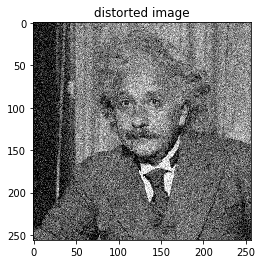

In [352]:
#input_img = content_i.clone()
"""

gaussian blur


"""

# imgn = cv2.imread("./data/texture/pebbles.jpg")
# imgn = cv2.GaussianBlur(imgn, ksize = (0, 0),sigmaX = (6.5))


# imgn = cv_converter(imgn)

"""

gaussian noise


"""

k = 10
ref = ref_img.detach()
noise = torch.randn(1,nc,imsize,imsize)*torch.sqrt((torch.tensor([2.0])**k))/ torch.tensor(255.0) 
imgn = ref+noise.to(device)
imgn = torch.clamp(imgn,0,1)


"""

jpeg

"""
plt.figure()
imshow1(imgn, title='distorted image')

In [353]:
ref.shape

torch.Size([1, 1, 256, 256])

In [354]:
imgn.shape

torch.Size([1, 1, 256, 256])

In [355]:
model_style, style_losses = get_style_model_and_losses(cnn,
          cnn_normalization_mean, cnn_normalization_std, ref_img)

print(model_style)

imgn.data.clamp_(0,1)
input_img = imgn.detach()
ref = ref_img.detach()
cu = 0

iterations = 1000
lamda = 0.2
for i in range(iterations):
    
    #loss1, g1 = model_gram(model_style, input_img.detach(), style_losses)
    loss1, g1 = mse(input_img.detach(), ref.detach())
    #ssim(input_img.detach(), ref.detach())
    
    print('loss1',loss1)
    #plt.hist(g1.cpu(),1000)
    #plt.show()
    print('g1',g1.max(),g1.min(),torch.mean(torch.abs(g1)))
    
    
    print('g1',g1.max(),g1.min(),torch.mean(torch.abs(g1)))
    #loss2, g2 = mse(input_img.detach(), ref.detach())
    #loss2, g2 = model_gram(model_style, input_img.detach(), style_losses)
    loss2, g2 = ssim(input_img.detach(), ref.detach())
    
    print('\n\n\n')
    
    print('loss2',loss2)
    #plt.hist(g2.cpu(),1000)
    #plt.show()
    print('g2',g2.max(),g2.min(),torch.mean(torch.abs(g2)))
    
    sgn = torch.dot(g2,g_prev)
    if sgn > 0:
        lamda = 1.2*lamda
    else:
        lamda = lamda*0.2
    
    print('lamda:', lamda)
    g_prev = g2
    y, comp = search_grad(ref.detach(), g = g2, gkeep = g1, img = input_img.detach(), mkeep = mse, lamda = lamda)

    cu = cu + comp
    print('cumulate comp:', cu)
    if comp > 1:
        torch.save(y,'temp.pt')  
        break
        
    plt.figure()
    imshow(torch.clamp(y,0,1))
        
    input_img = y
    

/home/x227guo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/x227guo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/x227guo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


Sequential(
  (0): Normalization()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_1): StyleLoss()
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_2): ReLU()
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (style_loss_2): StyleLoss()
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_4): ReLU()
  (pool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (style_loss_4): StyleLoss()
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_5): ReLU()
  (conv_6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_6): ReLU()
  (conv_7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu_7): ReLU()
  (conv_8): Co

KeyboardInterrupt: 

In [ ]:
torch.save(input_img, 'pebbles_noise_1.pt')

In [ ]:
#im = torch.load( 'pebbles_blur6.5_5.pt')

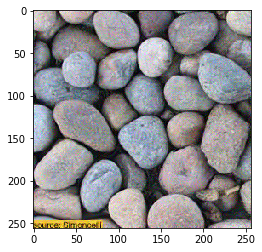

In [179]:
plt.figure()
imshow(input_img)
#imshow(im)